# Project Proposal (Group 93)
## Water Potability

### Introduction
Potable water (water that is safe to drink) is a basic requirement for human life. Lack of access to potable water is an issue that continues to affect many regions globally. The United Nations Sustainable Development Goal 6 is accordingly: "Ensure availability and sustainable management of water and sanitation for all”. According to the most recent report from the World Health Organization (WHO) (https://www.who.int/publications/i/item/9789240060807), in 2020 an estimated 26% of the global population (1.97 billion individuals) did not have access to safely managed drinking water services. Researching sufficiently fast, reliable, and cost-effective ways of evaluating the safety of drinking water is crucial to addressing this issue. In 2016, UNICEF called for the production of rapid-test kits for detecting the bacterium *Escherichia coli* (usually present in fecally contaminated water) (https://www.unicef.org/innovation/rapid-water-quality-testing). Apart from microbes, various other factors affect water potability.

In this project, we will utilize a synthetically generated dataset (https://www.kaggle.com/datasets/adityakadiwal/water-potability) containing over 3000 observations, each representing a sample of water. Each observation contains nine variables that affect water potability (pH, hardness, total dissolved solids, chloramines, sulphate, conductivity, organic carbon, trihalomethanes, and turbidity) as well as a score indicating whether or not the water is potable. Using this dataset, we aim to demonstrate how a classification model can be trained to accurately evaluate whether or not an unknown sample of water is potable based on measurable variables.

### Preliminary exploratory data analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

#1. READ DATA
water_potability_raw <- read_csv("data/water_potability.csv") #unedited "raw" dataset

nrow(water_potability_raw) #show number of observations in the raw dataset.

head(water_potability_raw)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

[1] 3276

ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,204.8905,20791.32,7.300212,368.5164,564.3087,10.379783,86.99097,2.963135,0
3.716080,129.4229,18630.06,6.635246,NA,592.8854,15.180013,56.32908,4.500656,0
8.099124,224.2363,19909.54,9.275884,NA,418.6062,16.868637,66.42009,3.055934,0
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0


In [2]:
#2. CLEAN DATA AND REMOVE NA ROWS
water_potability_clean <- water_potability_raw |>
    rename(hardness = Hardness, solids = Solids, chloramines = Chloramines, sulfate = Sulfate, conductivity = Conductivity, organic_carbon = Organic_carbon, trihalomethanes = Trihalomethanes, turbidity = Turbidity, potability = Potability) |>
    mutate(potability = as_factor(potability)) |>
    na.omit()

nrow(water_potability_clean) #number of observations in the cleaned dataset (NA removed)
head(water_potability_clean)

[1] 2011

ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0
10.223862,248.0717,28749.72,7.513408,393.6634,283.6516,13.789695,84.60356,2.672989,0
8.635849,203.3615,13672.09,4.563009,303.3098,474.6076,12.363817,62.79831,4.401425,0
11.180284,227.2315,25484.51,9.077200,404.0416,563.8855,17.927806,71.97660,4.370562,0


In [3]:
#3. CREATE TRAINING DATA
water_split <- water_potability_clean |> #split the data 0.75/0.25
    initial_split(prop = 0.75, strata = potability) 

water_train <- training(water_split)  #set the 0.75 split as the training data

potability,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,7.113240,195.8360,21577.09,7.107026,334.1551,430.4820,14.37775,66.261,3.956864,900
1,7.116114,196.7291,22516.79,7.198894,331.9520,426.3451,14.30787,66.565,3.986921,608


ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.6931333,0.5777467,0.3872443,0.5518984,0.5978377,0.2816588,0.6900007,0.7950293,0.6301148,0
0.7595788,0.4413003,0.3151508,0.4159045,0.4396463,0.3463785,0.3525588,0.2029143,0.5203580,0
0.4589822,0.4708756,0.5073624,0.5056484,0.4956223,0.1291818,0.1976028,0.4014872,0.2199730,0
0.8565439,0.7159419,0.5073808,0.5028201,0.7222825,0.1350447,0.4620305,0.6586777,0.2424281,0
0.7204741,0.5325876,0.2382838,0.2375807,0.4165490,0.4866981,0.3920779,0.4697617,0.5850489,0
0.9384955,0.6304770,0.4491052,0.6434042,0.7573997,0.6511069,0.6650434,0.5492804,0.5789311,0


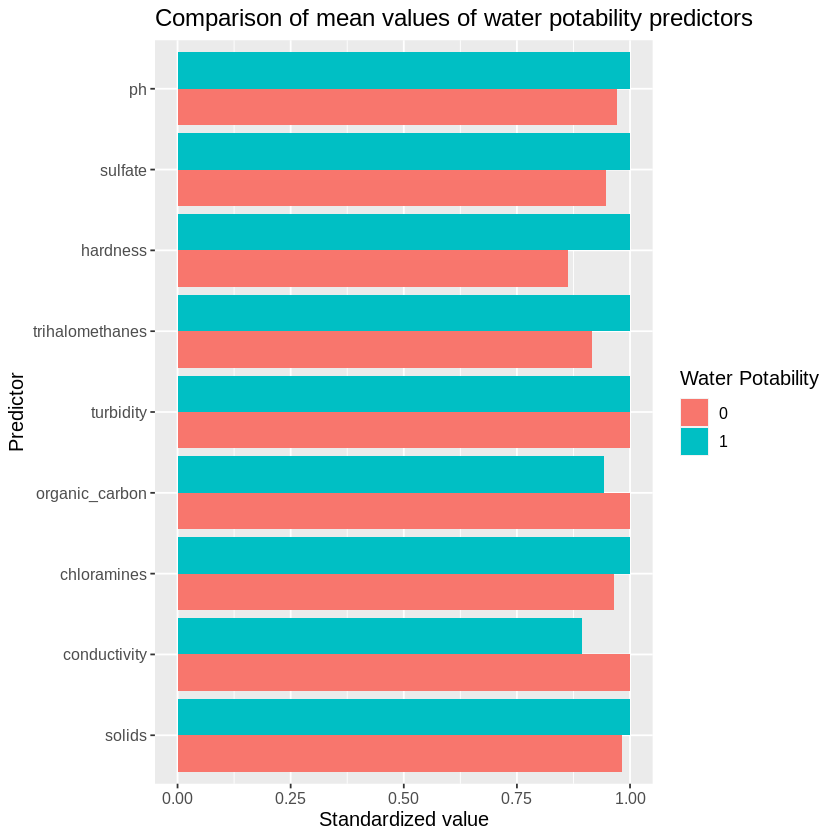

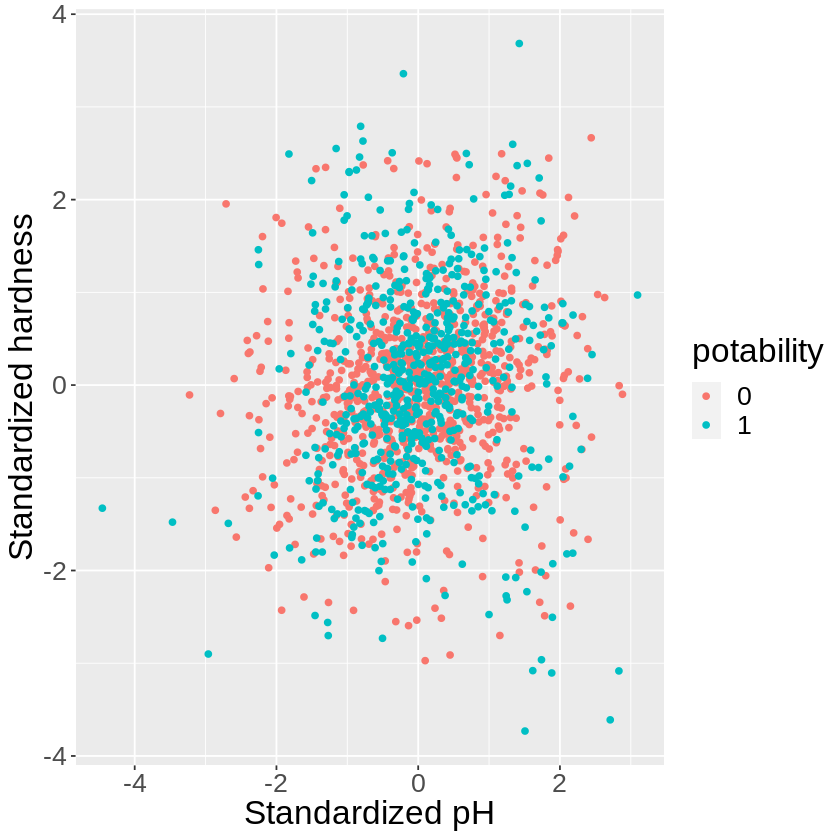

In [4]:
#4. SUMMARIZE DATA IN A TABLE
water_train_means <- water_train |> #find means for all predictors grouped by potability
    group_by(potability) |>
    summarize(across(ph:turbidity, mean, na.rm=TRUE))

water_train_nrows <- water_train |> #count number of observations in the two groups
    group_by(potability) |>
    summarize(n = n())

water_train_summary <- water_train_means |> #merge grouped n dataframe with grouped means dataframe
    merge(water_train_nrows)

water_train_summary

#5. SCALE TRAINING DATA (0 to 1)
min_table <- water_train |> #min value of all predictors
    select(-potability) |>
    map_df(min)

max_table <- water_train |> #max value of all predictors
    select(-potability) |>
    map_df(max)

diff_table <- max_table - min_table #max - min for all predictors

water_train_scaled <- water_train |> #scale all predictors X (0 to 1) according to (Xi - Xmin)/(Xmax - Xmin)
    select(-potability) |>
    mutate(ph = (ph - min_table$ph) / diff_table$ph, 
           hardness = (hardness - min_table$hardness) / diff_table$hardness,
           solids = (solids - min_table$solids) / diff_table$solids, 
           chloramines = (chloramines - min_table$chloramines) / diff_table$chloramines,
           sulfate = (sulfate - min_table$sulfate) / diff_table$sulfate, 
           conductivity = (conductivity - min_table$conductivity) / diff_table$conductivity,
           organic_carbon = (organic_carbon - min_table$organic_carbon) / diff_table$organic_carbon, 
           trihalomethanes = (trihalomethanes - min_table$trihalomethanes) / diff_table$trihalomethanes,
           turbidity = (turbidity - min_table$turbidity) / diff_table$turbidity) |>
    bind_cols(potability = water_train$potability)

head(water_train_scaled)

#6. PLOT SCALED TRAINING DATA (0-1) IN A BARPLOT SHOWING MEANS OF EACH PREDICTOR
water_train_scaled_longer <- water_train_scaled |> #pivot longer, generating columns "predictor" and "value"
    pivot_longer(c(ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, trihalomethanes, turbidity), names_to = "predictor")

water_train_barplot <- water_train_scaled_longer |> #barplot showing the scaled (0 to 1) means of each predictor grouped by potability
    ggplot(aes(y = reorder(predictor, value),x = value, fill = potability)) + 
    geom_col(position = 'dodge') + 
    xlab("Standardized value") +
    ylab("Predictor") +
    labs(fill = "Water Potability") +
    ggtitle("Comparison of mean values of water potability predictors") +
    theme(text = element_text(size = 12))

water_train_barplot

#7. SCALE TRAINING DATA USING SCALE()
water_train_scaled_2 <- water_train |> #scale all predictors using the scale() function
    select(-potability) |>
    scale(center = TRUE, scale = TRUE) |>
    bind_cols(potability = water_train$potability)

#8. PLOT SCALED TRAINING DATA IN A SCATTERPLOT COMPARING THE DISTRIBUTION ACCORDING TO TWO SELECTED PREDICTORS
water_train_scatterplot <- water_train_scaled_2 |> #scatterplot comparing two predictors--in this case, pH and hardness, standardized
    ggplot(aes(x = ph, y = hardness, color = potability)) +
    geom_point() +
    labs(x = "Standardized pH", y = "Standardized hardness") +
    theme(text = element_text(size = 20))

water_train_scatterplot

### Methods
Before beginning the data analysis, we import the water_potability dataset and split it into training and testing datasets plying a 75-25 split. We then deal with the NULL values and factor the potability of the dataset. Since we are examining every factor that influences water's potability, we will use all of the dataset's columns throughout the project as predictors and potability as the value of the variable that we are predicting. Additionally, we will present our dataset in a visual format to demonstrate the factors that contribute to the water's drinkability. Furthermore, we will start the classification process by creating the recipe for the prediction. We then would create the classifier specification and train the classifier using the training dataset and create a K-nearest neighbour classifier object. This object and the testing dataset can then be used to predict whether a particular sample of water is safe for human consumption. Additionally, we can even calculate the accuracy of our classifier's predictions.

Results will be visualized with multiple scatterplots (example shown above) comparing the distributions of any two predictors, demonstrating the viability of each predictor in the classification of water potability. There will also be an accompanying table describing the metrics (such as accuracy) of our classification model.

### Expected outcomes and significance

Our goal is to show how a classification model can be trained to accurately determine, based on measurable variables such as pH, Hardness, Turbidity etc, whether an unknown sample of water is potable.
Water is a basic requirement for human life. Lack of access to potable water is an issue that continues to affect many regions globally. Using this prediction we hope to recognize which and how many water bodies are not safe to drink and what causes that variability.
After prediction, we would need to study the non-potable water carefully and analyze which factors are responsible for making it unsafe to consume.